In [1]:
import cv2
import numpy as np
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os

class ScratchSegDataset(Dataset):
    def __init__(self, names_list, img_dir= "/kaggle/input/mowito/data/images",mask_dir="/kaggle/input/mowito/data/masks",
                 augment=False, img_size=512):
        self.names = names_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.augment = augment
        self.img_size = img_size

        self.t_train = A.Compose([
            A.Resize(img_size, img_size),
            A.RandomBrightnessContrast(p=0.4),
            A.Rotate(limit=8, p=0.4),
            A.MotionBlur(p=0.3),
            A.GaussNoise(p=0.3),
            A.HorizontalFlip(p=0.5),
            A.Normalize(),
            ToTensorV2()
        ])

        self.t_val = A.Compose([
            A.Resize(img_size, img_size),
            A.Normalize(),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        name = self.names[idx]

        img_path = os.path.join(self.img_dir, name)
        img = cv2.imread(img_path)[:,:,::-1]

        mask_path = os.path.join(self.mask_dir, name)

        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = (mask > 127).astype("uint8")
        else:
            mask = np.zeros(img.shape[:2], dtype="uint8")

        if self.augment:
            aug = self.t_train(image=img, mask=mask)
        else:
            aug = self.t_val(image=img, mask=mask)

        img_t = aug["image"]
        mask_t = aug["mask"].unsqueeze(0).float()

        return img_t, mask_t

In [2]:
pip install segmentation-models-pytorch tqdm numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.0 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch, os, time
import numpy as np
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
import torch.nn as nn
from tqdm import tqdm
DEVICE="cuda"

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [5]:

def dice_loss(pred, target, eps=1e-6):
    num = 2 * (pred * target).sum()
    den = pred.sum() + target.sum() + eps
    return 1 - num / den

def load_names(path):
    return [x.strip() for x in open(path).readlines()]

@torch.no_grad()
def validate(model, loader):
    model.eval()
    dices = []
    for img, mask in loader:
        img, mask = img.to(DEVICE), mask.to(DEVICE)
        p = torch.sigmoid(model(img))
        p_bin = (p > 0.5).float()
        d = 1 - dice_loss(p_bin, mask)
        dices.append(d.item())
    return np.mean(dices)




In [6]:

def main():

    train_names = load_names("/kaggle/input/mowito/data/splits/train.txt")
    val_names = load_names("/kaggle/input/mowito/data/splits/val.txt")
    
    ds_tr = ScratchSegDataset(train_names, augment=True)
    ds_va = ScratchSegDataset(val_names, augment=False)

    dl_tr = DataLoader(ds_tr, batch_size=8, shuffle=True, num_workers=4)
    dl_va = DataLoader(ds_va, batch_size=4, shuffle=False, num_workers=2)

    model = smp.Unet("efficientnet-b0", classes=1, in_channels=3).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=1e-4)

    os.makedirs("weights", exist_ok=True)

    best_dice = 0
    last_backup_time = time.time()
    BACKUP_INTERVAL = 180

    for epoch in range(1, 21):
        model.train()
        total_loss = 0

        for img, mask in tqdm(dl_tr):
            img, mask = img.to(DEVICE), mask.to(DEVICE)
            opt.zero_grad()

            logits = model(img)
            loss_bce = nn.BCEWithLogitsLoss()(logits, mask)
            loss_dice = dice_loss(torch.sigmoid(logits), mask)
            loss = loss_bce + loss_dice

            loss.backward()
            opt.step()
            total_loss += loss.item()

            if time.time() - last_backup_time > BACKUP_INTERVAL:
                torch.save(model.state_dict(), "weights/backup_latest.pth")
                last_backup_time = time.time()
                print("🟡 Saved periodic backup checkpoint")

        val_dice = validate(model, dl_va)
        print(f"Epoch {epoch}: Train Loss={total_loss/len(dl_tr):.4f}, Val Dice={val_dice:.4f}")


        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), "weights/best_unet.pth")
            print("🟢 Saved BEST model!")

        torch.save(model.state_dict(), "weights/last_epoch.pth")
        print("🔵 Saved last epoch model")

if __name__ == "__main__":
    main()


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


Epoch 1: Train Loss=1.1858, Val Dice=0.1231
🟢 Saved BEST model!
🔵 Saved last epoch model


 26%|██▌       | 134/518 [00:36<01:49,  3.50it/s]

🟡 Saved periodic backup checkpoint


100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


Epoch 2: Train Loss=0.7296, Val Dice=0.1467
🟢 Saved BEST model!
🔵 Saved last epoch model


 52%|█████▏    | 270/518 [01:12<01:11,  3.47it/s]

🟡 Saved periodic backup checkpoint


100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


Epoch 3: Train Loss=0.5205, Val Dice=0.1534
🟢 Saved BEST model!
🔵 Saved last epoch model


 78%|███████▊  | 406/518 [01:48<00:32,  3.46it/s]

🟡 Saved periodic backup checkpoint


100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


Epoch 4: Train Loss=0.4770, Val Dice=0.1529
🔵 Saved last epoch model


100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


Epoch 5: Train Loss=0.4249, Val Dice=0.1568
🟢 Saved BEST model!
🔵 Saved last epoch model


  0%|          | 1/518 [00:00<06:48,  1.27it/s]

🟡 Saved periodic backup checkpoint


100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


Epoch 6: Train Loss=0.4295, Val Dice=0.1592
🟢 Saved BEST model!
🔵 Saved last epoch model


 26%|██▋       | 137/518 [00:36<01:49,  3.47it/s]

🟡 Saved periodic backup checkpoint


100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


Epoch 7: Train Loss=0.4190, Val Dice=0.1616
🟢 Saved BEST model!
🔵 Saved last epoch model


 53%|█████▎    | 273/518 [01:13<01:10,  3.46it/s]

🟡 Saved periodic backup checkpoint


100%|██████████| 518/518 [02:18<00:00,  3.74it/s]


Epoch 8: Train Loss=0.4125, Val Dice=0.1602
🔵 Saved last epoch model


 79%|███████▉  | 409/518 [01:49<00:31,  3.47it/s]

🟡 Saved periodic backup checkpoint


100%|██████████| 518/518 [02:18<00:00,  3.74it/s]


Epoch 9: Train Loss=0.4083, Val Dice=0.1643
🟢 Saved BEST model!
🔵 Saved last epoch model


100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


Epoch 10: Train Loss=0.3994, Val Dice=0.1620
🔵 Saved last epoch model


  1%|          | 5/518 [00:01<02:51,  3.00it/s]

🟡 Saved periodic backup checkpoint


100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


Epoch 11: Train Loss=0.4071, Val Dice=0.1622
🔵 Saved last epoch model


 27%|██▋       | 141/518 [00:38<01:49,  3.44it/s]

🟡 Saved periodic backup checkpoint


100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


Epoch 12: Train Loss=0.4078, Val Dice=0.1624
🔵 Saved last epoch model


 53%|█████▎    | 277/518 [01:14<01:09,  3.48it/s]

🟡 Saved periodic backup checkpoint


100%|██████████| 518/518 [02:18<00:00,  3.74it/s]


Epoch 13: Train Loss=0.3801, Val Dice=0.1629
🔵 Saved last epoch model


 80%|███████▉  | 413/518 [01:50<00:30,  3.47it/s]

🟡 Saved periodic backup checkpoint


100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


Epoch 14: Train Loss=0.3764, Val Dice=0.1634
🔵 Saved last epoch model


100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


Epoch 15: Train Loss=0.3884, Val Dice=0.1636
🔵 Saved last epoch model


  2%|▏         | 8/518 [00:02<02:34,  3.30it/s]

🟡 Saved periodic backup checkpoint


100%|██████████| 518/518 [02:18<00:00,  3.74it/s]


Epoch 16: Train Loss=0.3767, Val Dice=0.1646
🟢 Saved BEST model!
🔵 Saved last epoch model


 28%|██▊       | 143/518 [00:38<01:48,  3.46it/s]

🟡 Saved periodic backup checkpoint


100%|██████████| 518/518 [02:18<00:00,  3.74it/s]


Epoch 17: Train Loss=0.3529, Val Dice=0.1644
🔵 Saved last epoch model


 54%|█████▍    | 280/518 [01:14<01:08,  3.47it/s]

🟡 Saved periodic backup checkpoint


100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


Epoch 18: Train Loss=0.3634, Val Dice=0.1648
🟢 Saved BEST model!
🔵 Saved last epoch model


 80%|████████  | 416/518 [01:51<00:29,  3.47it/s]

🟡 Saved periodic backup checkpoint


100%|██████████| 518/518 [02:18<00:00,  3.74it/s]


Epoch 19: Train Loss=0.3621, Val Dice=0.1639
🔵 Saved last epoch model


100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


Epoch 20: Train Loss=0.3572, Val Dice=0.1620
🔵 Saved last epoch model


In [4]:
import torch
print(f"Is GPU available? {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")

Is GPU available? True
GPU Device: Tesla P100-PCIE-16GB


In [7]:
import cv2
import numpy as np

def mask_to_bboxes(mask):
    mask = mask.astype("uint8")
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        boxes.append([x,y,x+w,y+h])
    return boxes

In [15]:
import torch, cv2, numpy as np
import segmentation_models_pytorch as smp


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = smp.Unet("efficientnet-b0", classes=1, in_channels=3)
model.load_state_dict(torch.load("/kaggle/working/weights/best_unet.pth", map_location=DEVICE))
model.to(DEVICE)
model.eval()

def infer(path, thresh=0.5):
    img0 = cv2.imread(path)
    if img0 is None:
        raise FileNotFoundError(path)

    img0 = img0[:, :, ::-1]
    h0, w0 = img0.shape[:2]

    img = cv2.resize(img0, (512, 512))
    img = img.astype(np.float32) / 255.0

    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

    img = (img - mean) / std

    img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)
    img = img.to(DEVICE, dtype=torch.float32)   # 🔑 FINAL GUARANTEE

    with torch.no_grad():
        p = torch.sigmoid(model(img))[0, 0].cpu().numpy()

    mask = (p > thresh).astype("uint8")
    mask = cv2.resize(mask, (w0, h0), interpolation=cv2.INTER_NEAREST)

    area_ratio = mask.sum() / (h0 * w0)
    bboxes = mask_to_bboxes(mask)
    is_bad = int(mask.sum() > 0)

    return mask, bboxes, area_ratio, is_bad


In [16]:
import os, cv2
from sklearn.metrics import precision_score, recall_score


def load_names(path):
    return [x.strip() for x in open(path).readlines()]

names = load_names("/kaggle/input/mowito/data/splits/test.txt")

y_true = []
y_pred = []

for name in names:
    mask_path = "/kaggle/input/mowito/data/masks/"
    gt = 1 if os.path.exists(mask_path) else 0
    pred_mask, _, _, pred = infer("/kaggle/input/mowito/data/images/" + name)

    y_true.append(gt)
    y_pred.append(pred)

from sklearn.metrics import confusion_matrix

print("Recall (bad images) =", recall_score(y_true, y_pred, pos_label=1))
print("Precision (bad predictions) =", precision_score(y_true, y_pred, pos_label=1))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Recall (bad images) = 0.20576923076923076
Precision (bad predictions) = 1.0
Confusion Matrix:
[[  0   0]
 [413 107]]


is_bad: 1
area_ratio: 0.03469793322734499
bboxes: [[118, 256, 120, 259], [33, 154, 122, 210], [64, 129, 65, 131]]


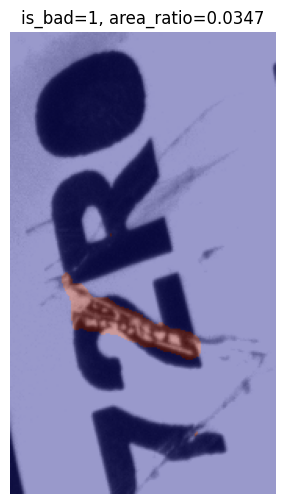

In [22]:
img_path = "/kaggle/input/mowito/data/images/bad_09_08_2024_18_27_49.795946_classifier_input.png"
mask, bboxes, area_ratio, is_bad = infer(img_path)

print("is_bad:", is_bad)
print("area_ratio:", area_ratio)
print("bboxes:", bboxes)
import matplotlib.pyplot as plt

img = cv2.imread(img_path)[:, :, ::-1]

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.imshow(mask, alpha=0.4, cmap="jet")
plt.title(f"is_bad={is_bad}, area_ratio={area_ratio:.4f}")
plt.axis("off")
plt.show()

